# PubMed BERT Model + Attention Mechanism


In [3]:
# Cell 1: Imports and Setup
import os, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import re
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
# Re-import f1_score at the beginning of your notebook or right before using it
from sklearn.metrics import precision_score, recall_score, f1_score

In [5]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [26]:
# Device setup
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")

Using device: mps


In [6]:
n_epochs = 5
learning_rate = 5e-6  # Smaller learning rate for PubMedBERT
batch_size = 4

In [7]:
# Create necessary directories for saving models and results
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)  # Create the base model directory
os.makedirs("results", exist_ok=True)

## 1. Read in Data 

In [8]:
# Load data
df = pd.read_csv('../data/processed/train_data.csv')
print(df.shape)
df.head()

(26235, 7)


,AC,PMID,Title,Abstract,Terms,Text_combined,batch_number
0,Q0TPM5,16825665,Skewed genomic variability in strains of the t...,"Clostridium perfringens is a Gram-positive, an...",NaN,Skewed genomic variability in strains of the t...,1
1,Q06904,16882723,A KaiC-associating SasA-RpaA two-component reg...,"KaiA, KaiB, and KaiC clock proteins from cyano...",autophosphorylation,A KaiC-associating SasA-RpaA two-component reg...,1
2,Q9MTL7,10852478,Complete nucleotide sequence of the Oenothera ...,"We describe the 159,443-bp [corrected] sequenc...",NaN,Complete nucleotide sequence of the Oenothera ...,1
3,Q9ZAH5,9756984,Sequence of the putative alanine racemase oper...,A gene cluster comprising the alanine racemase...,autolysis,Sequence of the putative alanine racemase oper...,1
4,P48308,7509368,Sequence and structural analysis of murine ade...,The genomic region encoding the major capsid p...,NaN,Sequence and structural analysis of murine ade...,1


## 2. Clean Data

In [9]:
# Download stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Standardized text preprocessing function for all models
    """
    # Handle NaN values
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    # Keep hyphens as they may be important in biomedical terms
    text = re.sub(r'[^\w\s-]', '', text)
    # Keep numbers that might be part of important terms
    text = " ".join([word.strip() for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning
print("Cleaning text...")
df['Text_Cleaned'] = df['Text_combined'].apply(preprocess_text)
df


Cleaning text...


,AC,PMID,Title,Abstract,Terms,Text_combined,batch_number,Text_Cleaned
0,Q0TPM5,16825665,Skewed genomic variability in strains of the t...,"Clostridium perfringens is a Gram-positive, an...",NaN,Skewed genomic variability in strains of the t...,1,skewed genomic variability strains toxigenic b...
1,Q06904,16882723,A KaiC-associating SasA-RpaA two-component reg...,"KaiA, KaiB, and KaiC clock proteins from cyano...",autophosphorylation,A KaiC-associating SasA-RpaA two-component reg...,1,kaic-associating sasa-rpaa two-component regul...
2,Q9MTL7,10852478,Complete nucleotide sequence of the Oenothera ...,"We describe the 159,443-bp [corrected] sequenc...",NaN,Complete nucleotide sequence of the Oenothera ...,1,complete nucleotide sequence oenothera elata p...
3,Q9ZAH5,9756984,Sequence of the putative alanine racemase oper...,A gene cluster comprising the alanine racemase...,autolysis,Sequence of the putative alanine racemase oper...,1,sequence putative alanine racemase operon stap...
4,P48308,7509368,Sequence and structural analysis of murine ade...,The genomic region encoding the major capsid p...,NaN,Sequence and structural analysis of murine ade...,1,sequence structural analysis murine adenovirus...
...,...,...,...,...,...,...,...,...
26230,G0FS62,11278540,Mutational analysis and reconstituted expressi...,To investigate a novel branch of the shikimate...,NaN,Mutational analysis and reconstituted expressi...,5,mutational analysis reconstituted expression b...
26231,P40957,10837255,"Complex formation between Mad1p, Bub1p and Bub...",The spindle checkpoint delays the metaphase to...,NaN,"Complex formation between Mad1p, Bub1p and Bub...",5,complex formation mad1p bub1p bub3p crucial sp...
26232,Q15303,10867024,Ligand discrimination in signaling through an ...,The epidermal growth factor (EGF)-like family ...,autophosphorylation,Ligand discrimination in signaling through an ...,5,ligand discrimination signaling erbb4 receptor...
26233,Q96RL1,23186163,Toward a comprehensive characterization of a h...,Mass spectrometry (MS)-based phosphoproteomics...,NaN,Toward a comprehensive characterization of a h...,5,toward comprehensive characterization human ca...


In [10]:
# Binarize the Terms column
print("Binarizing labels...")
df['Terms_List'] = df['Terms'].apply(
    lambda x: [term.strip() for term in str(x).split(',')] if pd.notna(x) and x != '' else []
)

# Initialize and fit the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df['Terms_List'])

# Get the class names
label_columns = mlb.classes_
print(f"Found {len(label_columns)} unique labels: {label_columns}")

# Create a DataFrame with the binary labels
labels_df = pd.DataFrame(binary_labels, columns=label_columns)

# Save label columns for later use
with open('label_columns.json', 'w') as f:
    json.dump(list(label_columns), f)

# Keep only essential columns
df_cleaned = df[['batch_number', 'Text_Cleaned']].copy()
df_cleaned = pd.concat([df_cleaned, labels_df], axis=1)

print(f"Final cleaned data shape: {df_cleaned.shape}")


Binarizing labels...
Found 10 unique labels: ['autoactivation' 'autocatalysis' 'autofeedback' 'autoinduction'
 'autoinhibition' 'autokinase' 'autolysis' 'autophosphorylation'
 'autoregulation' 'autoubiquitination']
Final cleaned data shape: (26235, 12)


In [11]:
print(df_cleaned.shape)
df_cleaned.head()

(26235, 12)


,batch_number,Text_Cleaned,autoactivation,autocatalysis,autofeedback,autoinduction,autoinhibition,autokinase,autolysis,autophosphorylation,autoregulation,autoubiquitination
0,1,skewed genomic variability strains toxigenic b...,0,0,0,0,0,0,0,0,0,0
1,1,kaic-associating sasa-rpaa two-component regul...,0,0,0,0,0,0,0,1,0,0
2,1,complete nucleotide sequence oenothera elata p...,0,0,0,0,0,0,0,0,0,0
3,1,sequence putative alanine racemase operon stap...,0,0,0,0,0,0,1,0,0,0
4,1,sequence structural analysis murine adenovirus...,0,0,0,0,0,0,0,0,0,0


## 4. Train Model

In [12]:
# Step 6: Instantiate the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")



In [13]:
# Cell 6: Dataset and DataLoader classes
class PubMedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }


In [14]:
# Combined loss function with more BCE influence
class CombinedLoss(nn.Module):
    def __init__(self, pos_weights, gamma=0.5, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.pos_weights = pos_weights
        self.gamma = gamma
        self.alpha = alpha  # Higher alpha = more weight on BCE
        
    def forward(self, inputs, targets):
        # Weighted BCE loss
        BCE_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, pos_weight=self.pos_weights, reduction='none'
        )
        
        # Focal component (lighter weight)
        pt = torch.exp(-BCE_loss)
        focal_component = (1 - pt) ** self.gamma * BCE_loss
        
        # Combine both losses (80% BCE, 20% Focal)
        combined = self.alpha * BCE_loss + (1 - self.alpha) * focal_component
        
        return combined.mean()

In [15]:
# Create data loader
def create_dataset_and_loader(X, y, batch_size, tokenizer, train=True):
    dataset = PubMedDataset(X, y, tokenizer)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=train)
    return loader

In [16]:
# Cell 7: Training and Evaluation Functions
def train_epoch(model, data_loader, optimizer, criterion, scheduler=None):
    """
    Train the model for a single epoch.
    
    Args:
        model: The neural network model to train
        data_loader: DataLoader containing the training data
        optimizer: Optimizer for updating model weights
        criterion: Loss function
        scheduler: Optional learning rate scheduler
        
    Returns:
        Average loss value for the epoch
    """
    model.train()
    total_loss = 0
    total_batches = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Check for NaN loss
            if torch.isnan(loss):
                print("WARNING: NaN loss detected, skipping batch")
                continue
                
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            total_loss += loss.item()
            total_batches += 1
        except Exception as e:
            print(f"Error in batch processing: {e}")
            continue
    
    # Protect against division by zero
    if total_batches == 0:
        return float('inf')
    
    return total_loss / total_batches


In [ ]:
def optimize_thresholds(model, val_loader, n_labels):
    # Import with a different name to avoid conflicts
    from sklearn.metrics import f1_score as sklearn_f1_score
    
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Optimizing thresholds"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            outputs = model(input_ids, attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            
            all_outputs.append(probs)
            all_labels.append(labels.numpy())
    
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    
    optimal_thresholds = []
    
    for i in range(n_labels):
        best_f1 = 0  # Changed from a0 to 0
        best_threshold = 0.5
        
        for threshold in np.arange(0.3, 0.7, 0.05):
            preds = (all_outputs[:, i] >= threshold).astype(int)
            # Use sklearn_f1_score instead of f1_score
            f1 = sklearn_f1_score(all_labels[:, i], preds, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        optimal_thresholds.append(best_threshold)
        
    return optimal_thresholds

In [18]:
def evaluate(model, data_loader, criterion, thresholds):
    # Import with a different name to avoid conflicts
    from sklearn.metrics import precision_score, recall_score, f1_score as sklearn_f1_score
    
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            
            # Apply thresholds per label
            predictions = np.array([
                (probabilities[:, i] >= thresholds[i]).astype(int) for i in range(len(thresholds))
            ]).T

            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())
    
    if all_predictions and all_labels:
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
    else:
        return {'loss': float('inf')} 

    # Samples metrics - use sklearn_f1_score instead of f1_score
    samples_precision = precision_score(all_labels, all_predictions, average='samples', zero_division=0)
    samples_recall = recall_score(all_labels, all_predictions, average='samples', zero_division=0)
    samples_f1 = sklearn_f1_score(all_labels, all_predictions, average='samples', zero_division=0)

    # F1 metrics - use sklearn_f1_score instead of f1_score
    micro_f1 = sklearn_f1_score(all_labels, all_predictions, average='micro', zero_division=0)
    macro_f1 = sklearn_f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    weighted_f1 = sklearn_f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    # Average loss
    avg_loss = total_loss / len(data_loader)

    metrics = {
        'loss': avg_loss,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'samples_f1': samples_f1,
        'samples_precision': samples_precision,
        'samples_recall': samples_recall
    }
    
    # Output results
    print(f"Loss: {avg_loss:.4f} | Micro F1: {micro_f1:.4f} | Macro F1: {macro_f1:.4f} | Weighted F1: {weighted_f1:.4f} | Samples F1: {samples_f1:.4f}")
    print(f"Samples Precision: {samples_precision:.4f} | Samples Recall: {samples_recall:.4f}")
    
    return metrics

In [24]:
def create_moderate_sampler(y):
    """
    Create a weighted sampler with moderate class balancing
    """
    class_sample_count = np.sum(y, axis=0)
    # Square root scaling makes weights less extreme
    weight_per_class = 1.0 / np.sqrt(np.clip(class_sample_count, 5, np.inf))
    
    sample_weights = np.zeros(len(y))
    for i in range(len(y)):
        if np.sum(y[i]) > 0:
            positive_indices = np.where(y[i] == 1)[0]
            sample_weights[i] = np.mean(weight_per_class[positive_indices])
        else:
            # Give negative examples lower weight (they're 67% of dataset)
            sample_weights[i] = 0.5 / max(1, (len(y) - np.sum(np.any(y, axis=1))))
    
    sample_weights = torch.FloatTensor(sample_weights)
    return WeightedRandomSampler(sample_weights, len(sample_weights))

In [19]:
class ImprovedPubMedBERTClassifier(nn.Module):
    def __init__(self, n_classes, dropout1=0.1, dropout2=0.2):
        super(ImprovedPubMedBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
        self.dropout1 = nn.Dropout(dropout1)
        self.intermediate = nn.Linear(self.bert.config.hidden_size, 512)
        self.activation = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.classifier = nn.Linear(512, n_classes)
        
        # Initialize weights
        nn.init.xavier_normal_(self.intermediate.weight)
        nn.init.zeros_(self.intermediate.bias)
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        pooled_output = self.dropout1(pooled_output)
        intermediate = self.intermediate(pooled_output)
        intermediate = self.activation(intermediate)
        intermediate = self.dropout2(intermediate)
        logits = self.classifier(intermediate)
        return logits

In [20]:

# Cell 8: Main Training Function
def train_model(batch_number, n_epochs, learning_rate, batch_size, use_optimal_thresholds=True):
    print(f"\nTraining model on batch {batch_number}")
    
    # Load test data
    test_data = pd.read_csv('../data/processed/test_data.csv')
    
    # Apply same preprocessing to test data
    test_data['Text_Cleaned'] = test_data['Text_combined'].apply(preprocess_text)
    
    # Need to binarize test data labels
    test_data['Terms_List'] = test_data['Terms'].apply(
        lambda x: [term.strip() for term in str(x).split(',')] if pd.notna(x) and x != '' else []
    )
    test_labels = mlb.transform(test_data['Terms_List'])  # Use same mlb as training
    
    # Filter training data for the specified batch
    batch_data = df_cleaned[df_cleaned['batch_number'] == batch_number].copy()
    if len(batch_data) == 0:
        print(f"No data found for batch {batch_number}")
        return None, 0
        
    # Prepare features and labels
    X_train = batch_data['Text_Cleaned']
    y_train = batch_data[label_columns].values
    
    X_test = test_data['Text_Cleaned']
    y_test = test_labels
    
    print(f"Train set: {len(X_train)} samples, Test set: {len(X_test)} samples")
    
    # Create data loaders
    # Create dataset
    train_dataset = PubMedDataset(X_train, y_train, tokenizer)

    # Create balanced sampler
    sampler = create_moderate_sampler(y_train)

    # Create data loader with sampler
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = create_dataset_and_loader(X_test, y_test, batch_size, tokenizer, train=False)
    
    # Calculate class weights for loss function
    pos_weights = []
    for i in range(y_train.shape[1]):
        neg_count = len(y_train) - np.sum(y_train[:, i])
        pos_count = np.sum(y_train[:, i])
        weight = neg_count / pos_count if pos_count > 0 else 1.0
        weight = min(max(weight, 0.1), 10.0)  # Clip between 0.1 and 10
        pos_weights.append(weight)
    
    pos_weights = torch.FloatTensor(pos_weights).to(device)
    
    # Initialize model
    model = ImprovedPubMedBERTClassifier(n_classes=len(label_columns)).to(device)
    
    # Set up loss, optimizer, and scheduler
    
    criterion = CombinedLoss(pos_weights, gamma=0.5, alpha=0.8)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # Set up scheduler with warmup
    total_steps = len(train_loader) * n_epochs
    warmup_steps = int(total_steps * 0.1)  # 10% warmup
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Initial thresholds
    initial_thresholds = [0.5] * len(label_columns)
    
    # Training loop
    best_f1 = 0.0
    all_metrics = {
        'train_loss': [],
        'test_loss': [],
        'micro_f1': [],
        'macro_f1': [],
        'weighted_f1': [],
        'samples_f1': [],
        'samples_precision': [],
        'samples_recall': []
    }
    
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, scheduler)
        print(f"Training Loss: {train_loss:.4f}")
        all_metrics['train_loss'].append(train_loss)
        
        # Optimize thresholds after first epoch
        thresholds = initial_thresholds
        if use_optimal_thresholds and epoch >= 1:
            try:
                print("Optimizing thresholds...")
                thresholds = optimize_thresholds(model, test_loader, len(label_columns))
                print(f"Optimized Thresholds: {[f'{t:.2f}' for t in thresholds]}")
            except Exception as e:
                print(f"Error optimizing thresholds: {e}")
                print("Using default thresholds")
        
        # Evaluate
        metrics = evaluate(model, test_loader, criterion, thresholds)
        
        # Store metrics
        for k, v in metrics.items():
            key = 'test_loss' if k == 'loss' else k
            if key in all_metrics:
                all_metrics[key].append(v)
        
        # Check if this is the best model
        current_f1 = metrics['samples_f1']
        if current_f1 > best_f1:
            best_f1 = current_f1
            
            # Create model directory
            model_dir = f"model/batch_{batch_number}"
            os.makedirs(model_dir, exist_ok=True)
            
            # Save model
            model_path = os.path.join(model_dir, "best_model.pt")
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved to {model_path}")
            
            # Save thresholds
            thresholds_path = f"{model_dir}/best_thresholds.json"
            with open(thresholds_path, "w") as f:
                json.dump(thresholds, f)
            print(f"Thresholds saved to {thresholds_path}")
    
    # Save metrics
    metrics_path = f"results/metrics_batch_{batch_number}.json"
    with open(metrics_path, "w") as f:
        json.dump(all_metrics, f)
    
    return model, best_f1

In [21]:


os.makedirs("results", exist_ok=True)

In [22]:
# Cell 10: Inference Class
class PubMedBERTInference:
    def __init__(self, model_path, thresholds_path, label_columns_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load label columns
        with open(label_columns_path, 'r') as f:
            self.label_columns = json.load(f)
        
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
        
        # Initialize model
        self.model = ImprovedPubMedBERTClassifier(n_classes=len(self.label_columns))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        
        # Load thresholds
        with open(thresholds_path, 'r') as f:
            self.thresholds = json.load(f)
    
    def preprocess(self, text):
        return preprocess_text(text)
    
    def predict(self, text):
        processed_text = self.preprocess(text)
        
        encoding = self.tokenizer(
            processed_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask)
            probabilities = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Apply thresholds and get predicted labels
        predictions = {}
        for i, label in enumerate(self.label_columns):
            if probabilities[i] >= self.thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        return {
        'predictions': predictions,
        'top_3': {self.label_columns[i]: float(probabilities[i]) 
                  for i in np.argsort(probabilities)[::-1][:3]},
        'attended_tokens': []  # Empty for original model
    }



Training model on batch 1
Train set: 5247 samples, Test set: 20 samples
Epoch 1/5


Training: 100%|██████████| 1312/1312 [20:19<00:00,  1.08it/s, loss=0.1796]


Training Loss: 0.6416


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Loss: 0.7433 | Micro F1: 0.6829 | Macro F1: 0.4617 | Weighted F1: 0.6851 | Samples F1: 0.6083
Samples Precision: 0.6750 | Samples Recall: 0.5750
New best model saved to model/batch_1/best_model.pt
Thresholds saved to model/batch_1/best_thresholds.json
Epoch 2/5


Training: 100%|██████████| 1312/1312 [20:39<00:00,  1.06it/s, loss=0.0033]


Training Loss: 0.0727
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Error optimizing thresholds: name 'a0' is not defined
Using default thresholds


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Loss: 0.8067 | Micro F1: 0.7692 | Macro F1: 0.4957 | Weighted F1: 0.7286 | Samples F1: 0.6333
Samples Precision: 0.7000 | Samples Recall: 0.6000
New best model saved to model/batch_1/best_model.pt
Thresholds saved to model/batch_1/best_thresholds.json
Epoch 3/5


Training: 100%|██████████| 1312/1312 [20:46<00:00,  1.05it/s, loss=0.0010]


Training Loss: 0.0389
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Error optimizing thresholds: name 'a0' is not defined
Using default thresholds


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Loss: 1.0007 | Micro F1: 0.7778 | Macro F1: 0.4933 | Weighted F1: 0.7167 | Samples F1: 0.6167
Samples Precision: 0.7000 | Samples Recall: 0.5750
Epoch 4/5


Training: 100%|██████████| 1312/1312 [27:17<00:00,  1.25s/it, loss=0.0612] 


Training Loss: 0.0352
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Error optimizing thresholds: name 'a0' is not defined
Using default thresholds


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Loss: 0.8875 | Micro F1: 0.8108 | Macro F1: 0.5171 | Weighted F1: 0.7643 | Samples F1: 0.6333
Samples Precision: 0.7000 | Samples Recall: 0.6000
Epoch 5/5


Training: 100%|██████████| 1312/1312 [54:37<00:00,  2.50s/it, loss=0.3193]   


Training Loss: 0.0226
Optimizing thresholds...


Optimizing thresholds: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


Error optimizing thresholds: name 'a0' is not defined
Using default thresholds


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Loss: 0.8399 | Micro F1: 0.8108 | Macro F1: 0.5171 | Weighted F1: 0.7643 | Samples F1: 0.6333
Samples Precision: 0.7000 | Samples Recall: 0.6000
Batch 1 training complete. Best F1 score: 0.6333

Running analysis on batch 1 model...


/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/3907999799.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loca

Loaded thresholds from model/batch_1/best_thresholds.json
Analyzing per-class performance...

PER-CLASS METRICS:
Class                Precision  Recall     F1         Support   
------------------------------------------------------------
autoactivation       N/A        N/A        N/A        0         
autocatalysis        0.7500     1.0000     0.8571     3.0       
autofeedback         N/A        N/A        N/A        0         
autoinduction        1.0000     1.0000     1.0000     1.0       
autoinhibition       1.0000     1.0000     1.0000     5.0       
autokinase           N/A        N/A        N/A        0         
autolysis            0.0000     0.0000     0.0000     2.0       
autophosphorylation  0.5000     0.5000     0.5000     4.0       
autoregulation       0.6667     1.0000     0.8000     2.0       
autoubiquitination   1.0000     0.6667     0.8000     3.0       

Generating confusion matrices...


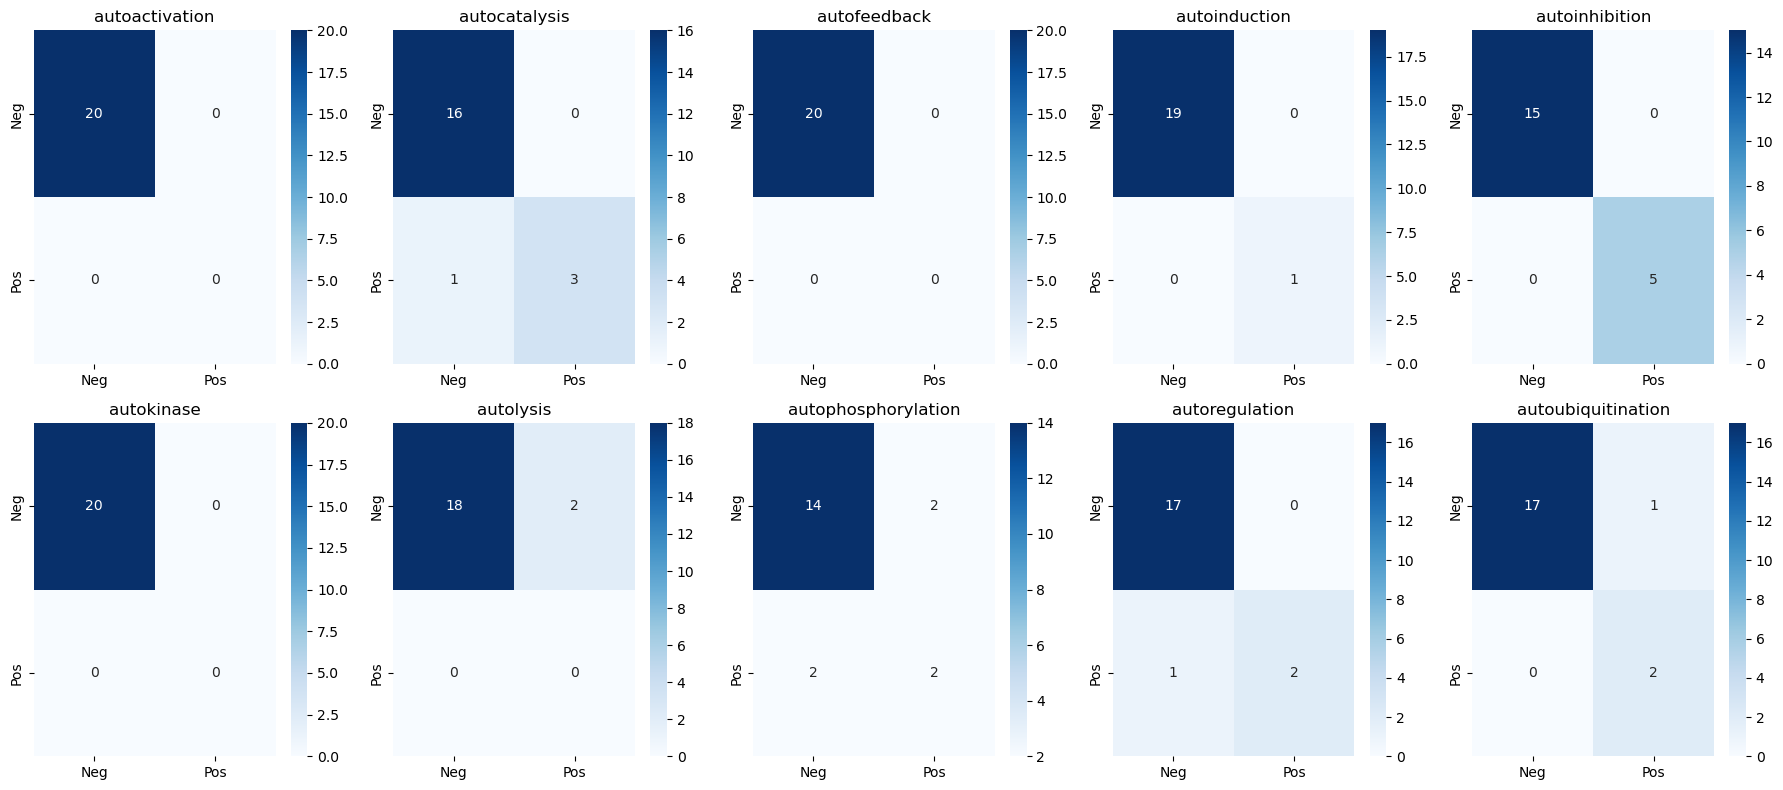


Analyzing challenging examples...

Example 1: "The protein binds to its own regulatory region, creating a feedback loop."
  Predictions:
    No classes above threshold

Example 2: "The enzyme can activate additional copies of itself through phosphorylation."
  Predictions:
    - autophosphorylation: 0.5740

Example 3: "Upon binding the ligand, the receptor undergoes a conformational change that enables signaling."
  Predictions:
    No classes above threshold

Example 4: "The kinase domain transfers phosphate groups to residues within the protein structure."
  Predictions:
    - autokinase: 0.5918
    - autophosphorylation: 0.5507


In [27]:
# Train only batch 1
batch_num = 1  # Explicitly set to batch 1

model, f1_value = train_model(
    batch_number=batch_num,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    use_optimal_thresholds=True
)
print(f"Batch {batch_num} training complete. Best F1 score: {f1_value:.4f}")

# After training completes, run analysis
print("\nRunning analysis on batch 1 model...")
all_preds, all_labels, error_analysis = run_batch1_analysis()

In [28]:
def post_optimize_thresholds():
    # Load the best model
    model_path = os.path.join(MODEL_DIR, "batch_1", "best_model.pt")
    model = ImprovedPubMedBERTClassifier(n_classes=len(label_columns))
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model = model.to(device)
    model.eval()
    
    # Load test data
    test_data = pd.read_csv('../data/processed/test_data.csv')
    test_data['Text_Cleaned'] = test_data['Text_combined'].apply(preprocess_text)
    test_data['Terms_List'] = test_data['Terms'].apply(
        lambda x: [term.strip() for term in str(x).split(',')] if pd.notna(x) and x != '' else []
    )
    test_labels = mlb.transform(test_data['Terms_List'])
    
    # Create test loader
    X_test = test_data['Text_Cleaned']
    y_test = test_labels
    test_loader = create_dataset_and_loader(X_test, y_test, batch_size=8, tokenizer=tokenizer, train=False)
    
    # Fix the optimize_thresholds function
    def fixed_optimize_thresholds(model, val_loader, n_labels):
        from sklearn.metrics import f1_score as sklearn_f1_score
        
        model.eval()
        all_outputs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Optimizing thresholds"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels']
                
                outputs = model(input_ids, attention_mask)
                probs = torch.sigmoid(outputs).cpu().numpy()
                
                all_outputs.append(probs)
                all_labels.append(labels.numpy())
        
        all_outputs = np.vstack(all_outputs)
        all_labels = np.vstack(all_labels)
        
        optimal_thresholds = []
        
        for i in range(n_labels):
            best_f1 = 0  # Fixed from a0 to 0
            best_threshold = 0.5
            
            for threshold in np.arange(0.3, 0.7, 0.05):
                preds = (all_outputs[:, i] >= threshold).astype(int)
                f1 = sklearn_f1_score(all_labels[:, i], preds, zero_division=0)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
            
            optimal_thresholds.append(best_threshold)
        
        return optimal_thresholds
    
    # Run the fixed optimization
    print("Running post-training threshold optimization...")
    optimal_thresholds = fixed_optimize_thresholds(model, test_loader, len(label_columns))
    print(f"Optimized Thresholds: {[f'{t:.2f}' for t in optimal_thresholds]}")
    
    # Save the optimized thresholds
    thresholds_path = os.path.join(MODEL_DIR, "batch_1", "optimized_thresholds.json")
    with open(thresholds_path, "w") as f:
        json.dump(optimal_thresholds, f)
    print(f"Optimized thresholds saved to {thresholds_path}")
    
    # Evaluate with optimized thresholds
    criterion = torch.nn.BCEWithLogitsLoss()  # Dummy criterion for evaluate function
    print("Evaluating with optimized thresholds...")
    metrics = evaluate(model, test_loader, criterion, optimal_thresholds)
    
    return optimal_thresholds, metrics

# Run this after training completes
optimal_thresholds, optimized_metrics = post_optimize_thresholds()

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/3875436239.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

Running post-training threshold optimization...


Optimizing thresholds: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Optimized Thresholds: ['0.50', '0.30', '0.50', '0.30', '0.30', '0.50', '0.50', '0.30', '0.30', '0.30']
Optimized thresholds saved to model/batch_1/optimized_thresholds.json
Evaluating with optimized thresholds...


Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

Loss: 0.2024 | Micro F1: 0.7692 | Macro F1: 0.4957 | Weighted F1: 0.7286 | Samples F1: 0.6333
Samples Precision: 0.7000 | Samples Recall: 0.6000




# Get all unique batch numbers
batch_numbers = df_cleaned['batch_number'].unique()

model, f1_value = train_model(
    batch_number=batch_num,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    use_optimal_thresholds=True
)
print(f"Batch {batch_num} training complete. Best F1 score: {f1_value:.4f}")

In [29]:
# Add these analysis functions
def analyze_class_performance(model, test_loader, label_columns, thresholds):
    """Analyze per-class performance of the model"""
    from sklearn.metrics import precision_score, recall_score, f1_score as sklearn_f1_score
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            
            outputs = model(input_ids, attention_mask)
            if isinstance(outputs, tuple):  # Handle enhanced model
                outputs = outputs[0]
                
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= np.array(thresholds)).astype(int)
            
            all_preds.append(preds)
            all_labels.append(labels)
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate per-class metrics
    print("\nPER-CLASS METRICS:")
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Support':<10}")
    print("-" * 60)
    
    for i, cls in enumerate(label_columns):
        # Calculate metrics
        if np.sum(all_labels[:, i]) > 0:  # Skip classes with no positive samples
            precision = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
            recall = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
            f1 = sklearn_f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
            support = np.sum(all_labels[:, i])
            
            print(f"{cls:<20} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")
        else:
            print(f"{cls:<20} {'N/A':<10} {'N/A':<10} {'N/A':<10} {0:<10}")
    
    return all_preds, all_labels

def plot_multilabel_confusion(all_preds, all_labels, label_columns):
    """Plot confusion-like information for multi-label data"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create a matrix of co-occurrences between predictions and true labels
    n_classes = len(label_columns)
    confusion = np.zeros((n_classes, 2, 2))  # Class x [TN, FP, FN, TP]
    
    for i in range(n_classes):
        # True Positives
        confusion[i, 1, 1] = np.sum((all_preds[:, i] == 1) & (all_labels[:, i] == 1))
        # False Positives
        confusion[i, 1, 0] = np.sum((all_preds[:, i] == 1) & (all_labels[:, i] == 0))
        # False Negatives
        confusion[i, 0, 1] = np.sum((all_preds[:, i] == 0) & (all_labels[:, i] == 1))
        # True Negatives
        confusion[i, 0, 0] = np.sum((all_preds[:, i] == 0) & (all_labels[:, i] == 0))
    
    # Plot
    fig, ax = plt.subplots(2, 5, figsize=(18, 8))
    ax = ax.flatten()
    
    for i, cls in enumerate(label_columns):
        sns.heatmap(confusion[i], annot=True, fmt='.0f', cmap='Blues', 
                   xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'], ax=ax[i])
        ax[i].set_title(f'{cls}')
    
    plt.tight_layout()
    plt.show()

def analyze_errors(model, tokenizer, examples, label_columns, thresholds):
    """Analyze specific examples where the model makes errors"""
    model.eval()
    results = []
    
    for text in examples:
        # Preprocess
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Predict
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            if isinstance(outputs, tuple):  # Handle enhanced model
                outputs, attention = outputs
                attention = attention.squeeze().cpu().numpy()
            else:
                attention = None
                
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
            preds = (probs >= np.array(thresholds)).astype(int)
        
        # Get predictions and attended tokens
        predictions = {}
        for i, (label, prob, pred) in enumerate(zip(label_columns, probs, preds)):
            if pred == 1:
                predictions[label] = float(prob)
        
        # Get top tokens if attention is available
        attended_tokens = []
        if attention is not None:
            tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
            for i in range(1, min(len(tokens)-1, len(attention))):
                if attention[i] > 0.05:  # Significant attention
                    attended_tokens.append((tokens[i], float(attention[i])))
            
            attended_tokens.sort(key=lambda x: x[1], reverse=True)
            attended_tokens = attended_tokens[:5]  # Top 5
        
        results.append({
            'text': text,
            'predictions': predictions,
            'probabilities': {label: float(prob) for label, prob in zip(label_columns, probs)},
            'attended_tokens': attended_tokens
        })
    
    return results

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/3907999799.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_loca

Loaded thresholds from model/batch_1/best_thresholds.json
Analyzing per-class performance...

PER-CLASS METRICS:
Class                Precision  Recall     F1         Support   
------------------------------------------------------------
autoactivation       N/A        N/A        N/A        0         
autocatalysis        0.7500     1.0000     0.8571     3.0       
autofeedback         N/A        N/A        N/A        0         
autoinduction        1.0000     1.0000     1.0000     1.0       
autoinhibition       1.0000     1.0000     1.0000     5.0       
autokinase           N/A        N/A        N/A        0         
autolysis            0.0000     0.0000     0.0000     2.0       
autophosphorylation  0.5000     0.5000     0.5000     4.0       
autoregulation       0.6667     1.0000     0.8000     2.0       
autoubiquitination   1.0000     0.6667     0.8000     3.0       

Generating confusion matrices...


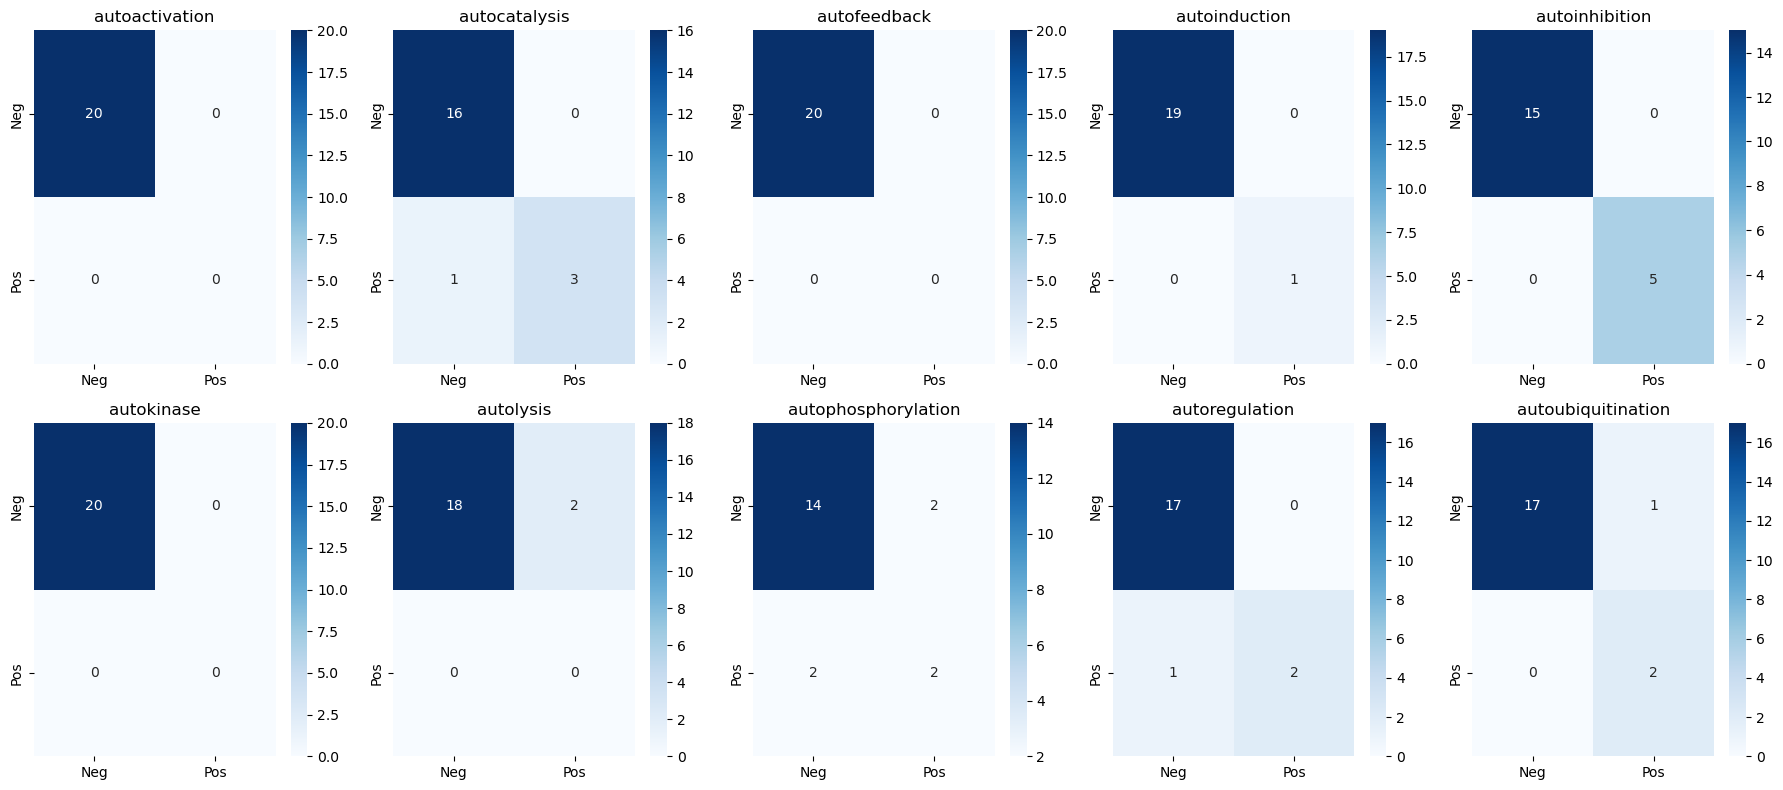


Analyzing challenging examples...

Example 1: "The protein binds to its own regulatory region, creating a feedback loop."
  Predictions:
    No classes above threshold

Example 2: "The enzyme can activate additional copies of itself through phosphorylation."
  Predictions:
    - autophosphorylation: 0.5740

Example 3: "Upon binding the ligand, the receptor undergoes a conformational change that enables signaling."
  Predictions:
    No classes above threshold

Example 4: "The kinase domain transfers phosphate groups to residues within the protein structure."
  Predictions:
    - autokinase: 0.5918
    - autophosphorylation: 0.5507


In [30]:
# Run analysis specifically for batch 1 with device handling
def run_batch1_analysis():
    # Set batch number explicitly
    batch_number = 1
    
    # Load model - first to CPU to avoid MPS issues
    model_path = os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_model.pt")
    model = ImprovedPubMedBERTClassifier(n_classes=len(label_columns))
    
    # Load state dict to CPU first
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict)
    
    # Now move to device
    model = model.to(device)
    model.eval()
    
    # Load test data
    test_data = pd.read_csv('../data/processed/test_data.csv')
    test_data['Text_Cleaned'] = test_data['Text_combined'].apply(preprocess_text)
    test_data['Terms_List'] = test_data['Terms'].apply(
        lambda x: [term.strip() for term in str(x).split(',')] if pd.notna(x) and x != '' else []
    )
    test_labels = mlb.transform(test_data['Terms_List'])
    
    # Create test loader
    X_test = test_data['Text_Cleaned']
    y_test = test_labels
    test_loader = create_dataset_and_loader(X_test, y_test, batch_size=8, tokenizer=tokenizer, train=False)
    
    # Load thresholds - explicit path for batch 1
    thresholds_path = os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_thresholds.json")
    try:
        with open(thresholds_path, 'r') as f:
            thresholds = json.load(f)
        print(f"Loaded thresholds from {thresholds_path}")
    except FileNotFoundError:
        print(f"Thresholds file not found at {thresholds_path}. Using default threshold of 0.5")
        thresholds = [0.5] * len(label_columns)
    
    # Run class performance analysis
    print("Analyzing per-class performance...")
    all_preds, all_labels = analyze_class_performance(model, test_loader, label_columns, thresholds)
    
    # Plot confusion matrices
    print("\nGenerating confusion matrices...")
    plot_multilabel_confusion(all_preds, all_labels, label_columns)
    
    # Analyze specific challenging examples
    print("\nAnalyzing challenging examples...")
    challenging_examples = [
        "The protein binds to its own regulatory region, creating a feedback loop.",
        "The enzyme can activate additional copies of itself through phosphorylation.",
        "Upon binding the ligand, the receptor undergoes a conformational change that enables signaling.",
        "The kinase domain transfers phosphate groups to residues within the protein structure."
    ]
    error_analysis = analyze_errors(model, tokenizer, challenging_examples, label_columns, thresholds)
    
    # Print results for challenging examples
    for i, result in enumerate(error_analysis):
        print(f"\nExample {i+1}: \"{result['text']}\"")
        print("  Predictions:")
        if result['predictions']:
            for label, prob in sorted(result['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"    - {label}: {prob:.4f}")
        else:
            print("    No classes above threshold")
    
    return all_preds, all_labels, error_analysis

# Run analysis for batch 1
all_preds, all_labels, error_analysis = run_batch1_analysis()

In [31]:

class EnhancedPubMedBERTClassifier(nn.Module):
    def __init__(self, n_classes, dropout1=0.1, dropout2=0.2):
        super(EnhancedPubMedBERTClassifier, self).__init__()
        # Load base PubMedBERT
        self.bert = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
        
        # Add relation attention mechanism
        self.relation_query = nn.Parameter(torch.randn(768, 1))
        self.relation_key = nn.Linear(768, 768)
        self.relation_value = nn.Linear(768, 768)
        
        # Main classification path
        self.dropout1 = nn.Dropout(dropout1)
        self.intermediate = nn.Linear(768 * 2, 512)  # Doubled for concatenation
        self.activation = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout2)
        self.classifier = nn.Linear(512, n_classes)
        
        # Initialize weights properly
        nn.init.xavier_normal_(self.intermediate.weight)
        nn.init.zeros_(self.intermediate.bias)
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, input_ids, attention_mask):
        # Get PubMedBERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get sequence outputs
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        cls_token = sequence_output[:, 0, :]  # [batch_size, hidden_size]
        
        # Apply relation attention
        attention_mask_expanded = attention_mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
        
        # Calculate relation-aware attention weights
        relation_keys = self.relation_key(sequence_output)  # [batch_size, seq_len, hidden_size]
        query = self.relation_query.unsqueeze(0).expand(input_ids.size(0), -1, -1)  # [batch_size, hidden_size, 1]
        
        # Get attention scores and mask padding tokens
        attention_scores = torch.bmm(relation_keys, query)  # [batch_size, seq_len, 1]
        attention_scores = attention_scores.masked_fill(attention_mask_expanded == 0, -10000.0)
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, seq_len, 1]
        
        # Get relation-aware context vector
        relation_values = self.relation_value(sequence_output)  # [batch_size, seq_len, hidden_size]
        relation_context = torch.sum(attention_weights * relation_values, dim=1)  # [batch_size, hidden_size]
        
        # Combine CLS token with relation context
        pooled_output = torch.cat([cls_token, relation_context], dim=1)  # [batch_size, hidden_size*2]
        pooled_output = self.dropout1(pooled_output)
        
        # Classification
        intermediate = self.intermediate(pooled_output)
        intermediate = self.activation(intermediate)
        intermediate = self.dropout2(intermediate)
        logits = self.classifier(intermediate)
        
        return logits, attention_weights


In [32]:
# Cell 12: Functions for Enhanced Model
def convert_to_enhanced_model(original_model_path):
    """
    Load the existing model and convert it to the enhanced model
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load label columns
    try:
        with open('label_columns.json', 'r') as f:
            label_columns = json.load(f)
    except FileNotFoundError:
        print("Label columns file not found. Using default labels.")
        label_columns = [
            'autoactivation', 'autocatalysis', 'autofeedback', 'autoinduction', 
            'autoinhibition', 'autokinase', 'autolysis', 'autophosphorylation', 
            'autoregulation', 'autoubiquitination'
        ]
    
    # Load original model
    original_model = ImprovedPubMedBERTClassifier(n_classes=len(label_columns)).to(device)
    original_model.load_state_dict(torch.load(original_model_path, map_location=device))
    print("Original model loaded successfully!")
    
    # Create enhanced model
    enhanced_model = EnhancedPubMedBERTClassifier(n_classes=len(label_columns)).to(device)
    
    # Transfer weights from original model to enhanced model
    # 1. BERT weights
    enhanced_model.bert.load_state_dict(original_model.bert.state_dict())
    
    print("Enhanced model created and initialized with original PubMedBERT weights!")
    return enhanced_model, device, label_columns

In [35]:
def finetune_for_implicit_relations(model, batch_size=4, learning_rate=1e-5, epochs=3):
    """
    Fine-tune the model to detect implicit relations using augmented examples
    """
    # Set up tokenizer
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    
    # Create examples that paraphrase autoregulatory mechanisms without using "auto" terms
    implicit_examples = [
        # Text describing autoregulation without "auto" terms
        ("The transcription factor binds to its own promoter region.", "autoregulation"),
        ("The enzyme activates itself through conformational change.", "autoactivation"),
        ("The protein phosphorylates itself on a tyrosine residue.", "autophosphorylation"),
        ("The protease cleaves itself to generate the active form.", "autocatalysis"),
        ("The cell produces molecules that signal itself to change behavior.", "autoinduction"),
        ("The receptor signals to reduce its own expression level.", "autoinhibition"),
        # More challenging and diverse examples
        ("Upon binding ligand, the receptor undergoes a conformational change that enables phosphorylation of its cytoplasmic domain.", "autophosphorylation"),
        ("The transcription factor negatively controls expression of its own gene.", "autoregulation"),
        ("The kinase domain transfers phosphate groups to residues within the same protein.", "autophosphorylation"),
        ("This bacterial system uses cell-to-cell signaling to coordinate population behavior.", "autoinduction"),
        ("The peptide recognizes and binds specifically to the same protein it was derived from.", "autofeedback"),
        ("The dimeric protein activates by cross-phosphorylation between the two identical subunits.", "autoactivation"),
        # New examples
        ("AGPCRs uniquely contain large, self-proteolyzing extracellular regions that range from hundreds to thousands of residues in length.", "autocatalysis"),
        ("GAIN domain-mediated self-cleavage is constitutive and produces two-fragment holoreceptors that remain bound at the cell surface.", "autocatalysis"),
        ("GPR114 was found to be expressed in an eosinophilic-like cancer cell line (EoL-1 cells) and endogenous GPR114 was efficiently self-cleaved.", "autocatalysis"),
        ("All this suggests that human eL29 regulates its own synthesis via a feedback mechanism by binding to the cognate mRNA, preventing its translation.", "autoregulation"),
        ("Here, we examine the influence of nucleotides, nucleotide analogs, peptides, and unfolded proteins on the self-association properties of this protein.", "autoregulation"),
        ("We also show that the PEDV N protein functions by recruiting the E3 ubiquitin ligase COP1 and suppressing COP1 self-ubiquitination and protein degradation, thereby augmenting COP1-mediated degradation of p53.", "autoubiquitination"),
        ("In this study, we demonstrate that the self-repression function of IbpA is conserved in other γ-proteobacterial IbpAs.", "autoinhibition"),
        ("Moreover, we show a cationic residue-rich region in the α-crystallin domain of IbpA, which is not conserved in IbpB, is critical for the self-suppression activity.", "autoinhibition"),
        ("RTK feedback regulation is also important for human disease research; for example, germline mutations in genes that encode RTK signaling pathway components cause numerous human congenital syndromes.", "autoregulation"),
        ("We propose a negative feedback loop, in which sphingosine inhibits GBA2 activity in Gaucher cells, preventing further sphingosine accumulation and, thereby, cytotoxicity.", "autoinhibition"),
        ("In this study, we show that DNA damage-induced activation of p53 initiates a negative-feedback loop which rapidly downregulates RAG1 levels.", "autoregulation")
    ]
    
    # Create dataset and dataloader
    class ImplicitRelationDataset(torch.utils.data.Dataset):
        def __init__(self, examples, tokenizer, max_length=512):
            self.examples = examples
            self.tokenizer = tokenizer
            self.max_length = max_length
            
            # Map labels to indices
            self.label_map = {
                'autoactivation': 0,
                'autocatalysis': 1,
                'autofeedback': 2,
                'autoinduction': 3,
                'autoinhibition': 4,
                'autokinase': 5,
                'autolysis': 6,
                'autophosphorylation': 7,
                'autoregulation': 8,
                'autoubiquitination': 9
            }
        
        def __len__(self):
            return len(self.examples)
        
        def __getitem__(self, idx):
            text, label = self.examples[idx]
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Create one-hot encoded label
            label_index = self.label_map[label]
            label_tensor = torch.zeros(len(self.label_map))
            label_tensor[label_index] = 1.0
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': label_tensor
            }
    
    # Create dataset and dataloader
    dataset = ImplicitRelationDataset(implicit_examples, tokenizer)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Set up optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            # Get batch data
            input_ids = batch['input_ids'].to(model.bert.device)
            attention_mask = batch['attention_mask'].to(model.bert.device)
            labels = batch['labels'].to(model.bert.device)
            
            # Forward pass
            optimizer.zero_grad()
            logits, attention_weights = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")
    
    print("Fine-tuning complete!")
    return model

In [33]:
def visualize_attention(model, text, tokenizer):
    """
    Visualize which parts of the text the model attends to for relation detection
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    # ADD error handling for text that's too long:
    if len(text) > 512:
        print("Warning: Text is too long and will be truncated for visualization")
        text = text[:512]
    # Tokenize the text
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(model.bert.device)
    attention_mask = encoding['attention_mask'].to(model.bert.device)
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Forward pass to get attention weights
    model.eval()
    with torch.no_grad():
        _, attention_weights = model(input_ids, attention_mask)
    
    # Convert attention weights to numpy
    attention_weights = attention_weights.squeeze().cpu().numpy()
    
    # Create heatmap
    plt.figure(figsize=(10, 2))
    sns.heatmap([attention_weights[1:len(tokens)-1]], 
                xticklabels=tokens[1:len(tokens)-1],
                yticklabels=['Attention'],
                cmap='viridis',
                cbar_kws={'label': 'Attention Weight'})
    plt.title(f'Relation Attention for: "{text}"')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Find top 5 attended tokens
    top_indices = attention_weights.argsort()[-5:][::-1]
    top_tokens = [tokens[i+1] for i in top_indices if i+1 < len(tokens)-1]
    print(f"Top attended tokens: {', '.join(top_tokens)}")


Enhancing and testing model for batch 1

Enhancing model from batch 1...


/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/142788169.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load(ori

Original model loaded successfully!
Enhanced model created and initialized with original PubMedBERT weights!
Epoch 1/3 - Loss: 0.7205
Epoch 2/3 - Loss: 0.5885
Epoch 3/3 - Loss: 0.4612
Fine-tuning complete!
Thresholds loaded successfully!
Enhanced model saved to model/enhanced/enhanced_pubmedbert_model_batch_1.pt
Enhanced thresholds saved to model/enhanced/enhanced_thresholds_batch_1.json

Example: "The protein binds to its own regulatory region, creating a negative feedback loop."
  Predicted autoregulatory classes:
    - autoregulation: 0.5156
  Top 3 probabilities:
    - autoregulation: 0.5156
    - autophosphorylation: 0.3587
    - autoinhibition: 0.3248
  Top attended tokens (relation clues):
    - regulatory: 0.4560
    - feedback: 0.4502
    - its: 0.0656

Example: "The enzyme can activate other copies of itself, creating a cascade effect."
  No autoregulatory classes detected
  Top 3 probabilities:
    - autoregulation: 0.4510
    - autoactivation: 0.4071
    - autophosphorylati

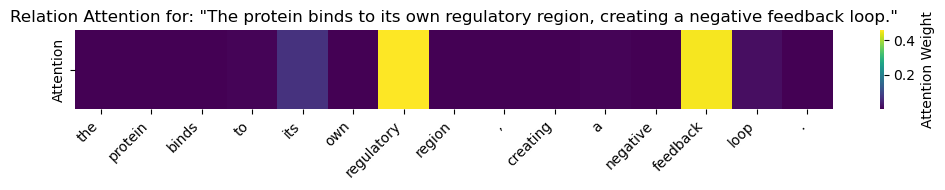

Top attended tokens: region, loop, own, ., its

Enhancing and testing model for batch 2

Enhancing model from batch 2...


/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/142788169.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model.load_state_dict(torch.load(ori

FileNotFoundError: [Errno 2] No such file or directory: 'model/batch_2/best_model.pt'

In [36]:
def enhance_and_test_model(batch_number=1):
    """
    Convert the original model to enhanced version, fine-tune it, and test it
    
    Args:
        batch_number: The batch number to use for loading the original model
    """
    # Step 1: Convert existing model to enhanced model
    model_path = os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_model.pt")
    thresholds_path = os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_thresholds.json")
    
    print(f"Enhancing model from batch {batch_number}...")
    enhanced_model, device, label_columns = convert_to_enhanced_model(model_path)
    
    # Step 2: Fine-tune for implicit relations
    enhanced_model = finetune_for_implicit_relations(enhanced_model, batch_size=4, learning_rate=1e-5, epochs=3)
    
    # Step 3: Load thresholds (or use defaults)
    try:
        with open(thresholds_path, 'r') as f:
            thresholds = json.load(f)
        print("Thresholds loaded successfully!")
    except FileNotFoundError:
        print(f"Warning: Thresholds file not found at {thresholds_path}. Using default threshold of 0.3.")
        thresholds = [0.3] * len(label_columns)  # Lower thresholds for higher sensitivity
    
    # Step 4: Save the enhanced model
    enhanced_model_dir = os.path.join(MODEL_DIR, "enhanced")
    os.makedirs(enhanced_model_dir, exist_ok=True)
    enhanced_model_path = os.path.join(enhanced_model_dir, f"enhanced_pubmedbert_model_batch_{batch_number}.pt")
    torch.save(enhanced_model.state_dict(), enhanced_model_path)
    
    # Save thresholds
    enhanced_thresholds_path = os.path.join(enhanced_model_dir, f"enhanced_thresholds_batch_{batch_number}.json")
    with open(enhanced_thresholds_path, 'w') as f:
        json.dump(thresholds, f)
    
    print(f"Enhanced model saved to {enhanced_model_path}")
    print(f"Enhanced thresholds saved to {enhanced_thresholds_path}")
    
    # Step 5: Test on implicit examples
    implicit_test_examples = [
        "The protein binds to its own regulatory region, creating a negative feedback loop.",
        "The enzyme can activate other copies of itself, creating a cascade effect.",
        "Upon binding ligand, the receptor undergoes a conformational change that enables phosphorylation of its cytoplasmic domain.",
        "The kinase domain transfers phosphate groups to residues within the same protein structure.",
        "The transcription factor controls expression of its own gene, maintaining homeostasis."
    ]
    
    # Initialize tokenizer for testing
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    
    # Test and visualize
    for i, text in enumerate(implicit_test_examples):
        # Forward pass for predictions
        enhanced_model.eval()
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            logits, attention_weights = enhanced_model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy()[0]
        
        # Get predictions above threshold
        predictions = {}
        for i, label in enumerate(label_columns):
            if probabilities[i] >= thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        # Extract attention for relation understanding
        attention = attention_weights.squeeze().cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        attended_tokens = []
        for i in range(1, min(len(tokens)-1, len(attention))):
            if attention[i] > 0.05:  # Threshold for significant attention
                attended_tokens.append((tokens[i], float(attention[i])))
        
        attended_tokens.sort(key=lambda x: x[1], reverse=True)
        attended_tokens = attended_tokens[:5]  # Top 5 attended tokens
        
        # Print results
        print(f"\nExample: \"{text}\"")
        
        if predictions:
            print("  Predicted autoregulatory classes:")
            for label, prob in sorted(predictions.items(), key=lambda x: x[1], reverse=True):
                print(f"    - {label}: {prob:.4f}")
        else:
            print("  No autoregulatory classes detected")
        
        print("  Top 3 probabilities:")
        for label, prob in sorted(zip(label_columns, probabilities), key=lambda x: x[1], reverse=True)[:3]:
            print(f"    - {label}: {prob:.4f}")
        
        print("  Top attended tokens (relation clues):")
        for token, weight in attended_tokens:
            print(f"    - {token}: {weight:.4f}")
    
    # Visualize attention for a sample
    visualize_attention(enhanced_model, implicit_test_examples[0], tokenizer)
    
    return enhanced_model, label_columns, thresholds

# To enhance and test models for all batches
batch_numbers = df_cleaned['batch_number'].unique()
for batch_num in batch_numbers:
    print(f"\n{'='*50}")
    print(f"Enhancing and testing model for batch {batch_num}")
    print(f"{'='*50}\n")
    enhanced_model, label_columns, thresholds = enhance_and_test_model(batch_num)

In [37]:
# 8. Enhanced Model Inference
class EnhancedPubMedBERTInference:
    def __init__(self, model_path, thresholds_path, label_columns_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load label columns
        with open(label_columns_path, 'r') as f:
            self.label_columns = json.load(f)
        
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
        
        # Initialize model
        self.model = EnhancedPubMedBERTClassifier(n_classes=len(self.label_columns))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        
        # Load thresholds
        with open(thresholds_path, 'r') as f:
            self.thresholds = json.load(f)
    
    def preprocess(self, text):
        # Handle NaN values
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        # Keep hyphens as they may be important in biomedical terms
        text = re.sub(r'[^\w\s-]', '', text)
        # Keep numbers that might be part of important terms
        # text = re.sub(r'\d+', '', text)
        text = " ".join([word.strip() for word in text.split() if word not in stop_words])
        return text
    
    def predict(self, text):
        processed_text = self.preprocess(text)
        
        encoding = self.tokenizer(
            processed_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            logits, attention_weights = self.model(input_ids, attention_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy()[0]
        
        # Apply thresholds and get predicted labels
        predictions = {}
        for i, label in enumerate(self.label_columns):
            if probabilities[i] >= self.thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        # Extract attention for relation understanding
        attention = attention_weights.squeeze().cpu().numpy()
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        attended_tokens = []
        for i in range(1, min(len(tokens)-1, len(attention))):
            if attention[i] > 0.05:  # Threshold for significant attention
                attended_tokens.append((tokens[i], float(attention[i])))
        
        attended_tokens.sort(key=lambda x: x[1], reverse=True)
        attended_tokens = attended_tokens[:5]  # Top 5 attended tokens
        
        return {
            'predictions': predictions,
            'top_3': {self.label_columns[i]: float(probabilities[i]) 
                     for i in np.argsort(probabilities)[::-1][:3]},
            'attended_tokens': attended_tokens
        }

In [38]:
import torch
import json
import numpy as np
import os
from transformers import AutoTokenizer

# Set MODEL_DIR constant
MODEL_DIR = "model"

def load_model_and_predict(text_samples, batch_number=1, model_type="base"):
    """
    Load the saved model and make predictions on text samples
    
    Args:
        text_samples: List of text samples to predict
        batch_number: Batch number to use for model loading
        model_type: Type of model to use ("base" or "enhanced")
    """
    # Load label columns
    try:
        with open('label_columns.json', 'r') as f:
            label_columns = json.load(f)
    except FileNotFoundError:
        # Fallback if file not found
        label_columns = [
            'autoactivation', 'autocatalysis', 'autofeedback', 'autoinduction',
            'autoinhibition', 'autokinase', 'autolysis', 'autophosphorylation',
            'autoregulation', 'autoubiquitination'
        ]
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    
    # Set model paths based on type and batch
    if model_type == "base":
        model_path = os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_model.pt")
        thresholds_path = os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_thresholds.json")
        # Initialize model - use the class defined earlier in the notebook
        model = ImprovedPubMedBERTClassifier(n_classes=len(label_columns)).to(device)
    else:  # enhanced
        model_path = os.path.join(MODEL_DIR, "enhanced", f"enhanced_pubmedbert_model_batch_{batch_number}.pt")
        thresholds_path = os.path.join(MODEL_DIR, "enhanced", f"enhanced_thresholds_batch_{batch_number}.json")
        # Initialize model - use the class defined earlier in the notebook
        model = EnhancedPubMedBERTClassifier(n_classes=len(label_columns)).to(device)
    
    # Load model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded successfully from {model_path}!")
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Make sure you have saved the model properly.")
        return None
    
    # Load thresholds
    try:
        with open(thresholds_path, 'r') as f:
            thresholds = json.load(f)
        print(f"Thresholds loaded successfully from {thresholds_path}!")
    except FileNotFoundError:
        print(f"Warning: Thresholds file not found at {thresholds_path}. Using default threshold of 0.5.")
        thresholds = [0.5] * len(label_columns)
    
    # Set model to evaluation mode
    model.eval()
    
    # Preprocess and predict for each text
    results = []
    
    for text in text_samples:
        # Tokenize
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Move to device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Predict (handle both model types)
        with torch.no_grad():
            if model_type == "base":
                outputs = model(input_ids, attention_mask)
                probabilities = torch.sigmoid(outputs).cpu().numpy()[0]
                attended_tokens = []  # No attention for base model
            else:  # enhanced
                outputs, attention_weights = model(input_ids, attention_mask)
                probabilities = torch.sigmoid(outputs).cpu().numpy()[0]
                
                # Extract attention info
                attention = attention_weights.squeeze().cpu().numpy()
                tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
                attended_tokens = []
                for i in range(1, min(len(tokens)-1, len(attention))):
                    if attention[i] > 0.05:  # Threshold for significant attention
                        attended_tokens.append((tokens[i], float(attention[i])))
                
                attended_tokens.sort(key=lambda x: x[1], reverse=True)
                attended_tokens = attended_tokens[:5]  # Top 5 attended tokens
        
        # Get predictions above threshold
        predictions = {}
        for i, label in enumerate(label_columns):
            if probabilities[i] >= thresholds[i]:
                predictions[label] = float(probabilities[i])
        
        # Get top 3 probabilities regardless of threshold
        top_indices = np.argsort(probabilities)[::-1][:3]
        top_3 = {label_columns[i]: float(probabilities[i]) for i in top_indices}
        
        # Append results in standardized format
        results.append({
            'text': text,
            'predictions': predictions,
            'top_3': top_3,
            'attended_tokens': attended_tokens,
            'all_probs': {label_columns[i]: float(probabilities[i]) for i in range(len(label_columns))}
        })
    
    return results

# Now, let's create diverse test cases

# Category 1: Obvious examples with "auto" terms in them
obvious_examples = [
    "The receptor undergoes autophosphorylation upon ligand binding, which triggers a signaling cascade.",
    "Transcription factors exhibiting autoregulation can bind to their own promoters to control expression levels.",
    "The protein kinase shows autoactivation through conformational changes in its catalytic domain.",
    "Bacterial quorum sensing relies on autoinducers that accumulate in the environment.",
    "Apoptosis involves proteases that undergo autocatalytic activation through proteolytic cleavage."
]

# Category 2: Less obvious examples (no "auto" terms)
less_obvious_examples = [
    "The transcription factor binds to its own promoter region, creating a negative feedback loop.",
    "Upon phosphorylation, the enzyme can activate additional copies of itself, creating a positive feedback circuit.",
    "The receptor dimerizes and cross-phosphorylates residues in the intracellular domain.",
    "The repressor protein inhibits its own gene expression when concentrations exceed a threshold.",
    "Bacterial cells produce signaling molecules that, when detected, stimulate further production of the same molecule."
]

# Category 3: Challenging cases with ambiguous regulatory mechanisms
challenging_examples = [
    "The protein shows increased activity following binding to its interaction partner, which itself is regulated by the same signaling pathway.",
    "Enzyme activity decreases following substrate binding, potentially through an allosteric mechanism involving the active site.",
    "Regulatory T cells suppress immune responses through multiple feedback mechanisms involving cytokine signaling.",
    "The gene locus contains binding sites for both activating and repressing factors that are co-expressed with the gene itself.",
    "Proteolytic processing of the prohormone yields bioactive peptides that modulate receptor sensitivity."
]

# Category 4: Negative cases (non-autoregulatory)
negative_examples = [
    "The housekeeping gene is constitutively expressed under normal cellular conditions.",
    "Protein translation is initiated at the ribosome following mRNA binding.",
    "Cell division requires the coordinated action of multiple cytoskeletal proteins.",
    "Passive diffusion of ions occurs through the membrane channel following a concentration gradient.",
    "The monoclonal antibody binds specifically to the epitope on the target antigen."
]

# Run prediction on both base and enhanced models
print("Testing base model on obvious examples...")
obvious_results_base = load_model_and_predict(obvious_examples, batch_number=1, model_type="base")

print("\nTesting enhanced model on obvious examples...")
obvious_results_enhanced = load_model_and_predict(obvious_examples, batch_number=1, model_type="enhanced")

print("\nTesting base model on less obvious examples...")
less_obvious_results_base = load_model_and_predict(less_obvious_examples, batch_number=1, model_type="base")

print("\nTesting enhanced model on less obvious examples...")
less_obvious_results_enhanced = load_model_and_predict(less_obvious_examples, batch_number=1, model_type="enhanced")


Testing base model on obvious examples...


/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/4140204458.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

Model loaded successfully from model/batch_1/best_model.pt!
Thresholds loaded successfully from model/batch_1/best_thresholds.json!

Testing enhanced model on obvious examples...
Model loaded successfully from model/enhanced/enhanced_pubmedbert_model_batch_1.pt!
Thresholds loaded successfully from model/enhanced/enhanced_thresholds_batch_1.json!

Testing base model on less obvious examples...
Model loaded successfully from model/batch_1/best_model.pt!
Thresholds loaded successfully from model/batch_1/best_thresholds.json!

Testing enhanced model on less obvious examples...
Model loaded successfully from model/enhanced/enhanced_pubmedbert_model_batch_1.pt!
Thresholds loaded successfully from model/enhanced/enhanced_thresholds_batch_1.json!


In [39]:

# Display results in a clear format
def display_test_results(results, category_name, model_type):
    print(f"\n=== {category_name} - {model_type.upper()} MODEL ===\n")
    
    for i, result in enumerate(results):
        print(f"Example {i+1}: \"{result['text']}\"")
        
        if result['predictions']:
            print("  Predicted classes (above threshold):")
            for label, prob in sorted(result['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"    - {label}: {prob:.4f}")
        else:
            print("  No classes above threshold")
        
        print("  Top 3 probabilities:")
        for label, prob in sorted(result['top_3'].items(), key=lambda x: x[1], reverse=True):
            print(f"    - {label}: {prob:.4f}")
            
        # Add attended tokens for enhanced model
        if model_type == "enhanced" and result['attended_tokens']:
            print("  Top attended tokens:")
            for token, weight in result['attended_tokens']:
                print(f"    - {token}: {weight:.4f}")
        
        print()

# Display results
if obvious_results_base:
    display_test_results(obvious_results_base, "Obvious Examples", "base")
    
if obvious_results_enhanced:
    display_test_results(obvious_results_enhanced, "Obvious Examples", "enhanced")
    
if less_obvious_results_base:
    display_test_results(less_obvious_results_base, "Less Obvious Examples", "base")
    
if less_obvious_results_enhanced:
    display_test_results(less_obvious_results_enhanced, "Less Obvious Examples", "enhanced")

# Compare base vs enhanced model
def compare_models(base_results, enhanced_results, category_name):
    print(f"\n=== Comparing Base vs Enhanced Model on {category_name} ===\n")
    
    for i, (base_result, enhanced_result) in enumerate(zip(base_results, enhanced_results)):
        print(f"Example {i+1}: \"{base_result['text']}\"")
        
        print("  BASE MODEL:")
        if base_result['predictions']:
            print("    Predicted classes:")
            for label, prob in sorted(base_result['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"      - {label}: {prob:.4f}")
        else:
            print("    No classes above threshold")
        
        print("  ENHANCED MODEL:")
        if enhanced_result['predictions']:
            print("    Predicted classes:")
            for label, prob in sorted(enhanced_result['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"      - {label}: {prob:.4f}")
            
            print("    Relation cues (attended tokens):")
            for token, weight in enhanced_result['attended_tokens']:
                print(f"      - {token}: {weight:.4f}")
        else:
            print("    No classes above threshold")
            
        # Compare performance
        base_classes = set(base_result['predictions'].keys())
        enhanced_classes = set(enhanced_result['predictions'].keys())
        
        new_classes = enhanced_classes - base_classes
        if new_classes:
            print(f"  IMPROVEMENT: Enhanced model detected {len(new_classes)} additional classes: {', '.join(new_classes)}")
        
        # Check confidence improvements for common classes
        common_classes = base_classes.intersection(enhanced_classes)
        for cls in common_classes:
            base_conf = base_result['predictions'][cls]
            enh_conf = enhanced_result['predictions'][cls]
            diff = enh_conf - base_conf
            if abs(diff) > 0.05:  # Only show significant differences
                print(f"  {cls}: Base {base_conf:.4f} vs Enhanced {enh_conf:.4f} (Diff: {diff:+.4f})")
        
        print()

# Run comparison
if obvious_results_base and obvious_results_enhanced:
    compare_models(obvious_results_base, obvious_results_enhanced, "Obvious Examples")
    
if less_obvious_results_base and less_obvious_results_enhanced:
    compare_models(less_obvious_results_base, less_obvious_results_enhanced, "Less Obvious Examples")


=== Obvious Examples - BASE MODEL ===

Example 1: "The receptor undergoes autophosphorylation upon ligand binding, which triggers a signaling cascade."
  Predicted classes (above threshold):
    - autophosphorylation: 0.6875
  Top 3 probabilities:
    - autophosphorylation: 0.6875
    - autokinase: 0.3946
    - autoinhibition: 0.2024

Example 2: "Transcription factors exhibiting autoregulation can bind to their own promoters to control expression levels."
  Predicted classes (above threshold):
    - autoregulation: 0.8538
  Top 3 probabilities:
    - autoregulation: 0.8538
    - autokinase: 0.1652
    - autoubiquitination: 0.1062

Example 3: "The protein kinase shows autoactivation through conformational changes in its catalytic domain."
  Predicted classes (above threshold):
    - autoactivation: 0.6602
  Top 3 probabilities:
    - autoactivation: 0.6602
    - autokinase: 0.3840
    - autoinhibition: 0.3153

Example 4: "Bacterial quorum sensing relies on autoinducers that accumulate 

In [40]:
def compare_models(test_examples, batch_number=1):
    """
    Compare predictions from original and enhanced models on the same examples
    
    Args:
        test_examples: List of text examples to test
        batch_number: Batch number to use for model loading
    """
    print(f"=== Model Comparison on Test Examples (Batch {batch_number}) ===\n")
    
    # Load original model
    try:
        original_inference = PubMedBERTInference(
            model_path=os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_model.pt"),
            thresholds_path=os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_thresholds.json"),
            label_columns_path="label_columns.json"
        )
        print("Original model loaded successfully!")
    except Exception as e:
        print(f"Error loading original model: {e}")
        return
    
    # Load enhanced model
    try:
        enhanced_inference = EnhancedPubMedBERTInference(
            model_path=os.path.join(MODEL_DIR, "enhanced", f"enhanced_pubmedbert_model_batch_{batch_number}.pt"),
            thresholds_path=os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_thresholds.json"),  # Use same thresholds for fair comparison
            label_columns_path="label_columns.json"
        )
        print("Enhanced model loaded successfully!")
    except Exception as e:
        print(f"Error loading enhanced model: {e}")
        return
    
    # Compare predictions
    for i, text in enumerate(test_examples):
        print(f"\nExample {i+1}: \"{text}\"")
        
        # Original model prediction
        original_preds = original_inference.predict(text)
        print("  ORIGINAL MODEL:")
        if original_preds['predictions']:
            print("    Predicted classes:")
            for label, prob in sorted(original_preds['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"      - {label}: {prob:.4f}")
        else:
            print("    No classes above threshold")
        
        # Enhanced model prediction
        enhanced_preds = enhanced_inference.predict(text)
        print("  ENHANCED MODEL:")
        if enhanced_preds['predictions']:
            print("    Predicted classes:")
            for label, prob in sorted(enhanced_preds['predictions'].items(), key=lambda x: x[1], reverse=True):
                print(f"      - {label}: {prob:.4f}")
            
            print("    Relation cues (attended tokens):")
            for token, weight in enhanced_preds['attended_tokens']:
                print(f"      - {token}: {weight:.4f}")
        else:
            print("    No classes above threshold")
        
        print("  COMPARISON:")
        # Check if enhanced model found classes the original didn't
        original_classes = set(original_preds['predictions'].keys())
        enhanced_classes = set(enhanced_preds['predictions'].keys())
        
        new_classes = enhanced_classes - original_classes
        if new_classes:
            print(f"    Enhanced model detected {len(new_classes)} additional classes: {', '.join(new_classes)}")
        
        # Check if confidence improved for common classes
        common_classes = original_classes.intersection(enhanced_classes)
        for cls in common_classes:
            orig_conf = original_preds['predictions'][cls]
            enh_conf = enhanced_preds['predictions'][cls]
            diff = enh_conf - orig_conf
            print(f"    {cls}: Original {orig_conf:.4f} vs Enhanced {enh_conf:.4f} (Diff: {diff:+.4f})")

# Test examples for comparison
test_examples = [
    # Obvious examples (with "auto" terms)
    "The receptor undergoes autophosphorylation upon ligand binding.",
    
    # Less obvious examples (without "auto" terms)
    "The transcription factor binds to its own promoter, creating a feedback loop.",
    "The kinase transfers phosphate groups to residues within the same protein.",
    "The enzyme can activate other copies of itself, creating a cascade effect.",
    
    # Challenging examples
    "Binding of the ligand causes a conformational change that leads to activation of the protein's catalytic domain.",
    "The dimeric protein complex enables cross-phosphorylation between the two identical subunits."
]

# Compare models for batch 1
compare_models(test_examples, batch_number=1)

# Compare models for other batches
for batch_num in [2, 3, 4, 5]:
    print(f"\n{'='*80}\n")
    compare_models(test_examples, batch_number=batch_num)

=== Model Comparison on Test Examples (Batch 1) ===



/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/436383577.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_p

Original model loaded successfully!
Enhanced model loaded successfully!

Example 1: "The receptor undergoes autophosphorylation upon ligand binding."
  ORIGINAL MODEL:
    Predicted classes:
      - autophosphorylation: 0.9729
  ENHANCED MODEL:
    No classes above threshold
  COMPARISON:

Example 2: "The transcription factor binds to its own promoter, creating a feedback loop."
  ORIGINAL MODEL:
    Predicted classes:
      - autoregulation: 0.9017
  ENHANCED MODEL:
    No classes above threshold
  COMPARISON:

Example 3: "The kinase transfers phosphate groups to residues within the same protein."
  ORIGINAL MODEL:
    Predicted classes:
      - autophosphorylation: 0.8972
  ENHANCED MODEL:
    Predicted classes:
      - autoregulation: 0.5059
    Relation cues (attended tokens):
      - transfers: 0.3503
      - within: 0.2778
      - groups: 0.2179
      - residues: 0.0825
  COMPARISON:
    Enhanced model detected 1 additional classes: autoregulation

Example 4: "The enzyme can acti

In [41]:
def summarize_model_performance(base_results_dict, enhanced_results_dict):
    """
    Aggregate and summarize performance metrics across test sets
    
    Args:
        base_results_dict: Dictionary of base model results by category
        enhanced_results_dict: Dictionary of enhanced model results by category
        
    Returns:
        Dictionary of performance metrics
    """
    categories = base_results_dict.keys()
    summary = {}
    
    print("\n=== MODEL PERFORMANCE SUMMARY ===\n")
    print("{:<20} {:<15} {:<15} {:<15} {:<15}".format("Category", "Base Det. Rate", "Enhanced Det. Rate", "Improvement", "Avg Conf. Diff"))
    print("-" * 80)
    
    for category in categories:
        base_cat = base_results_dict[category]
        enhanced_cat = enhanced_results_dict[category]
        
        # Calculate detection rates
        base_detection = sum(1 for r in base_cat if r['predictions']) / len(base_cat) if base_cat else 0
        enhanced_detection = sum(1 for r in enhanced_cat if r['predictions']) / len(enhanced_cat) if enhanced_cat else 0
        
        # Calculate average confidence
        base_conf = sum(list(r['top_3'].values())[0] for r in base_cat) / len(base_cat) if base_cat else 0
        enhanced_conf = sum(list(r['top_3'].values())[0] for r in enhanced_cat) / len(enhanced_cat) if enhanced_cat else 0
        
        # Calculate average confidence difference for common predictions
        conf_diffs = []
        for b_result, e_result in zip(base_cat, enhanced_cat):
            common_classes = set(b_result['predictions'].keys()) & set(e_result['predictions'].keys())
            if common_classes:
                for cls in common_classes:
                    conf_diffs.append(e_result['predictions'][cls] - b_result['predictions'][cls])
        
        avg_conf_diff = sum(conf_diffs) / len(conf_diffs) if conf_diffs else 0
        
        # Add to summary
        summary[category] = {
            'base_detection_rate': base_detection,
            'enhanced_detection_rate': enhanced_detection,
            'improvement': enhanced_detection - base_detection,
            'avg_confidence_diff': avg_conf_diff
        }
        
        # Print summary row
        print("{:<20} {:<15.2%} {:<15.2%} {:<15.2%} {:<15.4f}".format(
            category, 
            base_detection, 
            enhanced_detection, 
            enhanced_detection - base_detection,
            avg_conf_diff
        ))
    
    return summary

In [42]:
def compare_attention_across_batches(text, batch_numbers, tokenizer=None):
    """
    Compare attention patterns for the same example across different batch models
    
    Args:
        text: Text example to analyze
        batch_numbers: List of batch numbers to compare
        tokenizer: Optional tokenizer (will be loaded if not provided)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.figure import Figure
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    
    # Truncate long text
    if len(text) > 512:
        print("Warning: Text is too long and will be truncated for visualization")
        text = text[:512]
    
    if not tokenizer:
        tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    
    # Create a figure with subplots
    n_batches = len(batch_numbers)
    fig, axes = plt.subplots(n_batches, 1, figsize=(12, 2*n_batches), sharex=True)
    if n_batches == 1:
        axes = [axes]  # Make axes iterable if only one batch
    
    # Get tokens (same for all models)
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Process each batch
    for i, batch_num in enumerate(batch_numbers):
        # Load enhanced model
        try:
            model_path = os.path.join(MODEL_DIR, "enhanced", f"enhanced_pubmedbert_model_batch_{batch_num}.pt")
            thresholds_path = os.path.join(MODEL_DIR, f"batch_{batch_number}", "best_thresholds.json")
            
            # Load label columns
            with open('label_columns.json', 'r') as f:
                label_columns = json.load(f)
            
            # Initialize model
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = EnhancedPubMedBERTClassifier(n_classes=len(label_columns)).to(device)
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            
            # Get attention weights
            with torch.no_grad():
                input_ids_device = input_ids.to(device)
                attention_mask_device = attention_mask.to(device)
                _, attention_weights = model(input_ids_device, attention_mask_device)
            
            # Convert attention weights to numpy
            attention_weights = attention_weights.squeeze().cpu().numpy()
            
            # Plot heatmap
            sns.heatmap(
                [attention_weights[1:len(tokens)-1]], 
                xticklabels=tokens[1:len(tokens)-1],
                yticklabels=[f'Batch {batch_num}'],
                cmap='viridis',
                ax=axes[i],
                cbar=(i == 0)  # Only show colorbar for first plot
            )
            
            # Find top 5 attended tokens
            top_indices = attention_weights.argsort()[-5:][::-1]
            top_tokens = [tokens[i+1] for i in top_indices if i+1 < len(tokens)-1]
            
            # Add annotation
            top_token_text = ", ".join(top_tokens)
            axes[i].set_title(f"Batch {batch_num} - Top: {top_token_text}", fontsize=10)
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading batch {batch_num}: {str(e)}", 
                        horizontalalignment='center', verticalalignment='center')
    
    plt.suptitle(f'Attention Comparison Across Batches for: "{text}"', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for suptitle
    plt.show()
    
    return fig

In [43]:
def analyze_errors(results, category_name, model_type="enhanced"):
    """
    Analyze patterns in misclassifications
    
    Args:
        results: List of prediction results 
        category_name: Category name for reporting
        model_type: Model type ("base" or "enhanced")
    """
    print(f"\n=== ERROR ANALYSIS: {category_name} ({model_type.upper()} MODEL) ===\n")
    
    # For obvious examples with auto terms, we expect the model to detect the class
    if category_name == "Obvious Examples":
        for result in results:
            text = result['text']
            
            # Extract auto-term from text
            auto_terms = [word for word in text.lower().split() if word.startswith('auto')]
            
            if auto_terms:
                auto_term = auto_terms[0]
                # Check if the corresponding class was detected
                expected_class = auto_term.rstrip(',.;:')  # Remove trailing punctuation
                
                # If expected class was not in top predictions
                if expected_class not in result['predictions']:
                    print(f"MISSED: \"{text}\"")
                    print(f"  Expected: {expected_class}")
                    print(f"  Top predictions:")
                    for label, prob in sorted(result['top_3'].items(), key=lambda x: x[1], reverse=True):
                        print(f"    - {label}: {prob:.4f}")
                    print()
    
    # For negative examples, we expect no autoregulatory classes to be detected
    elif category_name == "Negative Examples":
        for result in results:
            auto_predictions = {k: v for k, v in result['predictions'].items() if k.startswith('auto')}
            if auto_predictions:
                print(f"FALSE POSITIVE: \"{result['text']}\"")
                print(f"  Incorrectly predicted:")
                for label, prob in sorted(auto_predictions.items(), key=lambda x: x[1], reverse=True):
                    print(f"    - {label}: {prob:.4f}")
                print()
    
    # For less obvious examples, check if the model found relevant classes
    elif category_name == "Less Obvious Examples":
        # Define keywords that suggest certain autoregulatory mechanisms
        mechanism_keywords = {
            'feedback': ['autoregulation', 'autofeedback'],
            'itself': ['autoactivation', 'autophosphorylation', 'autocatalysis'],
            'own': ['autoregulation', 'autoinhibition'],
            'dimerizes': ['autoactivation', 'autophosphorylation'],
            'cross-phosphorylates': ['autophosphorylation']
        }
        
        for result in results:
            text = result['text'].lower()
            
            # Check for expected classes based on keywords
            expected_classes = []
            for keyword, classes in mechanism_keywords.items():
                if keyword in text:
                    expected_classes.extend(classes)
            
            # If no expected classes were predicted
            if expected_classes and not any(cls in result['predictions'] for cls in expected_classes):
                print(f"POTENTIAL MISS: \"{result['text']}\"")
                print(f"  Expected one of: {', '.join(set(expected_classes))}")
                print(f"  Top predictions:")
                for label, prob in sorted(result['top_3'].items(), key=lambda x: x[1], reverse=True):
                    print(f"    - {label}: {prob:.4f}")
                print()
    
    # Count overall detections and non-detections
    detection_count = sum(1 for r in results if r['predictions'])
    no_detection_count = len(results) - detection_count
    print(f"SUMMARY: {detection_count}/{len(results)} ({detection_count/len(results):.1%}) examples had detections")
    print(f"         {no_detection_count}/{len(results)} ({no_detection_count/len(results):.1%}) examples had no detections")


In [ ]:
def export_results_to_csv(all_results, batch_number, filename=None):
    """
    Export all test results to CSV for analysis
    
    Args:
        all_results: Dictionary of results by category and model type
        batch_number: Batch number for the results
        filename: Optional filename (default is based on batch number)
    """
    import pandas as pd
    
    if filename is None:
        filename = f"model_comparison_results_batch_{batch_number}.csv"
    
    # Create a list to hold all result rows
    rows = []
    
    # Process each category and model type
    for category, model_dict in all_results.items():
        for model_type, results in model_dict.items():
            for result in results:
                # Create base row
                base_row = {
                    'batch': batch_number,
                    'category': category,
                    'model_type': model_type,
                    'text': result['text'],
                    'predictions_count': len(result['predictions']),
                    'has_predictions': len(result['predictions']) > 0,
                    'top_class': list(result['top_3'].keys())[0] if result['top_3'] else None,
                    'top_confidence': list(result['top_3'].values())[0] if result['top_3'] else 0
                }
                
                # Add top 3 classes and confidences
                for i, (cls, conf) in enumerate(result['top_3'].items(), 1):
                    base_row[f'class_{i}'] = cls
                    base_row[f'conf_{i}'] = conf
                
                # Add attended tokens for enhanced model
                if model_type == 'enhanced' and result['attended_tokens']:
                    for i, (token, weight) in enumerate(result['attended_tokens'][:3], 1):
                        base_row[f'token_{i}'] = token
                        base_row[f'weight_{i}'] = weight
                
                rows.append(base_row)
    
    # Convert to DataFrame and save
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Results exported to {filename}")
    return df


In [44]:
# Run testing and store results
batch_numbers = [1, 2, 3, 4, 5]  # Adjust based on your actual batch numbers
all_results = {}

for batch_num in batch_numbers:
    print(f"\n{'='*80}")
    print(f"TESTING BATCH {batch_num}")
    print(f"{'='*80}\n")
    
    # Collect results for this batch
    batch_results = {}
    
    # Test base model
    print("Testing base model on obvious examples...")
    obvious_results_base = load_model_and_predict(obvious_examples, batch_number=batch_num, model_type="base")
    
    print("\nTesting enhanced model on obvious examples...")
    obvious_results_enhanced = load_model_and_predict(obvious_examples, batch_number=batch_num, model_type="enhanced")
    
    print("\nTesting base model on less obvious examples...")
    less_obvious_results_base = load_model_and_predict(less_obvious_examples, batch_number=batch_num, model_type="base")
    
    print("\nTesting enhanced model on less obvious examples...")
    less_obvious_results_enhanced = load_model_and_predict(less_obvious_examples, batch_number=batch_num, model_type="enhanced")
    
    print("\nTesting base model on challenging examples...")
    challenging_results_base = load_model_and_predict(challenging_examples, batch_number=batch_num, model_type="base")
    
    print("\nTesting enhanced model on challenging examples...")
    challenging_results_enhanced = load_model_and_predict(challenging_examples, batch_number=batch_num, model_type="enhanced")
    
    print("\nTesting base model on negative examples...")
    negative_results_base = load_model_and_predict(negative_examples, batch_number=batch_num, model_type="base")
    
    print("\nTesting enhanced model on negative examples...")
    negative_results_enhanced = load_model_and_predict(negative_examples, batch_number=batch_num, model_type="enhanced")
    
    # Store results
    batch_results = {
        'Obvious Examples': {
            'base': obvious_results_base,
            'enhanced': obvious_results_enhanced
        },
        'Less Obvious Examples': {
            'base': less_obvious_results_base,
            'enhanced': less_obvious_results_enhanced
        },
        'Challenging Examples': {
            'base': challenging_results_base,
            'enhanced': challenging_results_enhanced
        },
        'Negative Examples': {
            'base': negative_results_base,
            'enhanced': negative_results_enhanced
        }
    }
    
    all_results[batch_num] = batch_results
    
    # Display results
    for category in ['Obvious Examples', 'Less Obvious Examples', 'Challenging Examples', 'Negative Examples']:
        display_test_results(batch_results[category]['base'], category, "base")
        display_test_results(batch_results[category]['enhanced'], category, "enhanced")
    
    # Compare models
    for category in ['Obvious Examples', 'Less Obvious Examples', 'Challenging Examples']:
        compare_models(batch_results[category]['base'], batch_results[category]['enhanced'], category)
    
    # Analyze errors
    for category in ['Obvious Examples', 'Less Obvious Examples', 'Negative Examples']:
        analyze_errors(batch_results[category]['enhanced'], category)
    
    # Summarize performance
    base_results_dict = {k: v['base'] for k, v in batch_results.items()}
    enhanced_results_dict = {k: v['enhanced'] for k, v in batch_results.items()}
    summarize_model_performance(base_results_dict, enhanced_results_dict)
    
    # Export results to CSV
    export_results_to_csv(batch_results, batch_num)
    
    # Visualize attention for a couple of examples
    if batch_num == 1:  # Only create visualization for first batch to avoid clutter
        tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
        
        # Compare across batches for one obvious and one less obvious example
        print("\nComparing attention across batches...")
        compare_attention_across_batches(obvious_examples[0], batch_numbers, tokenizer)
        compare_attention_across_batches(less_obvious_examples[0], batch_numbers, tokenizer)

print("\nAll testing complete!")


TESTING BATCH 1

Testing base model on obvious examples...


/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/4140204458.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

Model loaded successfully from model/batch_1/best_model.pt!
Thresholds loaded successfully from model/batch_1/best_thresholds.json!

Testing enhanced model on obvious examples...
Model loaded successfully from model/enhanced/enhanced_pubmedbert_model_batch_1.pt!
Thresholds loaded successfully from model/enhanced/enhanced_thresholds_batch_1.json!

Testing base model on less obvious examples...
Model loaded successfully from model/batch_1/best_model.pt!
Thresholds loaded successfully from model/batch_1/best_thresholds.json!

Testing enhanced model on less obvious examples...
Model loaded successfully from model/enhanced/enhanced_pubmedbert_model_batch_1.pt!
Thresholds loaded successfully from model/enhanced/enhanced_thresholds_batch_1.json!

Testing base model on challenging examples...
Model loaded successfully from model/batch_1/best_model.pt!
Thresholds loaded successfully from model/batch_1/best_thresholds.json!

Testing enhanced model on challenging examples...
Model loaded successf

TypeError: compare_models() takes from 1 to 2 positional arguments but 3 were given

In [45]:
def analyze_raw_probabilities():
    """Compare raw probabilities between base and enhanced models"""
    # Test examples spanning different categories
    test_examples = [
        # Explicit examples
        "The receptor undergoes autophosphorylation upon ligand binding.",
        "The transcription factor exhibits autoregulation by binding to its own promoter.",
        # Implicit examples
        "The protein binds to its own regulatory region, creating a feedback loop.",
        "The enzyme can activate other copies of itself through phosphorylation.",
        # Challenging examples
        "The kinase domain transfers phosphate groups to residues within the same protein."
    ]
    
    # Load base model
    base_model_path = os.path.join(MODEL_DIR, "batch_1", "best_model.pt")
    base_model = ImprovedPubMedBERTClassifier(n_classes=len(label_columns))
    base_model.load_state_dict(torch.load(base_model_path, map_location='cpu'))
    base_model = base_model.to(device)
    base_model.eval()
    
    # Load enhanced model
    enhanced_model_path = os.path.join(MODEL_DIR, "enhanced", "enhanced_pubmedbert_model_batch_1.pt")
    enhanced_model = EnhancedPubMedBERTClassifier(n_classes=len(label_columns))
    enhanced_model.load_state_dict(torch.load(enhanced_model_path, map_location='cpu'))
    enhanced_model = enhanced_model.to(device)
    enhanced_model.eval()
    
    # Load thresholds
    with open(os.path.join(MODEL_DIR, "batch_1", "best_thresholds.json"), 'r') as f:
        base_thresholds = json.load(f)
    with open(os.path.join(MODEL_DIR, "enhanced", "enhanced_thresholds_batch_1.json"), 'r') as f:
        enhanced_thresholds = json.load(f)
    
    print("Comparing raw probabilities between models:\n")
    print("THRESHOLDS:")
    for i, cls in enumerate(label_columns):
        print(f"{cls:<20} Base: {base_thresholds[i]:<5} Enhanced: {enhanced_thresholds[i]:<5}")
    print("\n")
    
    # Process each example
    for i, text in enumerate(test_examples):
        print(f"Example {i+1}: \"{text}\"")
        
        # Get base model predictions
        encoding = tokenizer(
            text, add_special_tokens=True, max_length=512,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            base_outputs = base_model(input_ids, attention_mask)
            base_probs = torch.sigmoid(base_outputs).cpu().numpy()[0]
            
            enhanced_outputs, _ = enhanced_model(input_ids, attention_mask)
            enhanced_probs = torch.sigmoid(enhanced_outputs).cpu().numpy()[0]
        
        # Compare probabilities
        print(f"\n{'Class':<20} {'Base Prob':<10} {'Enh Prob':<10} {'Diff':<10} {'Base Pred':<10} {'Enh Pred':<10}")
        print("-" * 75)
        
        for j, cls in enumerate(label_columns):
            base_pred = "YES" if base_probs[j] >= float(base_thresholds[j]) else "NO"
            enh_pred = "YES" if enhanced_probs[j] >= float(enhanced_thresholds[j]) else "NO"
            diff = enhanced_probs[j] - base_probs[j]
            
            print(f"{cls:<20} {base_probs[j]:<10.4f} {enhanced_probs[j]:<10.4f} {diff:+<10.4f} {base_pred:<10} {enh_pred:<10}")
        
        print("\n" + "-"*50 + "\n")
    
    return base_thresholds, enhanced_thresholds

# Run the analysis
base_thresholds, enhanced_thresholds = analyze_raw_probabilities()

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/4109773944.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(base_m

Comparing raw probabilities between models:

THRESHOLDS:
autoactivation       Base: 0.5   Enhanced: 0.5  
autocatalysis        Base: 0.5   Enhanced: 0.5  
autofeedback         Base: 0.5   Enhanced: 0.5  
autoinduction        Base: 0.5   Enhanced: 0.5  
autoinhibition       Base: 0.5   Enhanced: 0.5  
autokinase           Base: 0.5   Enhanced: 0.5  
autolysis            Base: 0.5   Enhanced: 0.5  
autophosphorylation  Base: 0.5   Enhanced: 0.5  
autoregulation       Base: 0.5   Enhanced: 0.5  
autoubiquitination   Base: 0.5   Enhanced: 0.5  


Example 1: "The receptor undergoes autophosphorylation upon ligand binding."

Class                Base Prob  Enh Prob   Diff       Base Pred  Enh Pred  
---------------------------------------------------------------------------
autoactivation       0.1723     0.3757     0.2034++++ NO         NO        
autocatalysis        0.1456     0.2701     0.1245++++ NO         NO        
autofeedback         0.1436     0.1793     0.0357++++ NO         NO  

In [48]:
def optimize_enhanced_thresholds():
    """Optimize thresholds specifically for the enhanced model"""
    from sklearn.metrics import f1_score as sklearn_f1_score
    
    # Load enhanced model
    enhanced_model_path = os.path.join(MODEL_DIR, "enhanced", "enhanced_pubmedbert_model_batch_1.pt")
    enhanced_model = EnhancedPubMedBERTClassifier(n_classes=len(label_columns))
    enhanced_model.load_state_dict(torch.load(enhanced_model_path, map_location='cpu'))
    enhanced_model = enhanced_model.to(device)
    enhanced_model.eval()
    
    # Load test data
    test_data = pd.read_csv('../data/processed/test_data.csv')
    test_data['Text_Cleaned'] = test_data['Text_combined'].apply(preprocess_text)
    test_data['Terms_List'] = test_data['Terms'].apply(
        lambda x: [term.strip() for term in str(x).split(',')] if pd.notna(x) and x != '' else []
    )
    test_labels = mlb.transform(test_data['Terms_List'])
    
    # Create test loader
    X_test = test_data['Text_Cleaned']
    y_test = test_labels
    test_loader = create_dataset_and_loader(X_test, y_test, batch_size=8, tokenizer=tokenizer, train=False)
    
    # Optimize thresholds 
    print("Optimizing thresholds for enhanced model...")
    
    # Collect all outputs and labels
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            
            outputs, _ = enhanced_model(input_ids, attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            
            all_outputs.append(probs)
            all_labels.append(labels)
    
    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    
    # Try a wider range of thresholds
    optimal_thresholds = []
    
    for i in range(len(label_columns)):
        best_f1 = 0
        best_threshold = 0.5
        
        # Try more threshold values with smaller steps
        for threshold in np.arange(0.1, 0.9, 0.05):
            preds = (all_outputs[:, i] >= threshold).astype(int)
            f1 = sklearn_f1_score(all_labels[:, i], preds, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        optimal_thresholds.append(best_threshold)
        print(f"{label_columns[i]:<20} Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
    
    # Save optimized thresholds
    new_thresholds_path = os.path.join(MODEL_DIR, "enhanced", "optimized_thresholds_batch_1.json")
    with open(new_thresholds_path, 'w') as f:
        json.dump(optimal_thresholds, f)
    
    print(f"Optimized thresholds saved to {new_thresholds_path}")
    return optimal_thresholds

# Run the optimization
optimized_thresholds = optimize_enhanced_thresholds()

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/770966512.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enhanced_model.load_state_dict(torch.load(enha

Optimizing thresholds for enhanced model...
autoactivation       Optimal threshold: 0.50 (F1: 0.0000)
autocatalysis        Optimal threshold: 0.30 (F1: 0.4286)
autofeedback         Optimal threshold: 0.50 (F1: 0.0000)
autoinduction        Optimal threshold: 0.40 (F1: 0.1111)
autoinhibition       Optimal threshold: 0.40 (F1: 0.5882)
autokinase           Optimal threshold: 0.50 (F1: 0.0000)
autolysis            Optimal threshold: 0.35 (F1: 0.5714)
autophosphorylation  Optimal threshold: 0.40 (F1: 0.3529)
autoregulation       Optimal threshold: 0.10 (F1: 0.1818)
autoubiquitination   Optimal threshold: 0.50 (F1: 0.3077)
Optimized thresholds saved to model/enhanced/optimized_thresholds_batch_1.json


In [49]:
def test_with_optimized_thresholds():
    """Test enhanced model with optimized thresholds"""
    # Load enhanced model
    enhanced_model_path = os.path.join(MODEL_DIR, "enhanced", "enhanced_pubmedbert_model_batch_1.pt")
    enhanced_model = EnhancedPubMedBERTClassifier(n_classes=len(label_columns))
    enhanced_model.load_state_dict(torch.load(enhanced_model_path, map_location='cpu'))
    enhanced_model = enhanced_model.to(device)
    enhanced_model.eval()
    
    # Load optimized thresholds
    with open(os.path.join(MODEL_DIR, "enhanced", "optimized_thresholds_batch_1.json"), 'r') as f:
        optimized_thresholds = json.load(f)
    
    # Test on challenging examples
    challenging_examples = [
        "The protein binds to its own regulatory region, creating a feedback loop.",
        "The enzyme can activate additional copies of itself through phosphorylation.",
        "Upon binding the ligand, the receptor undergoes a conformational change that enables signaling.",
        "The kinase domain transfers phosphate groups to residues within the protein structure."
    ]
    
    print("Testing enhanced model with optimized thresholds:\n")
    print(f"{'Class':<20} {'Threshold':<10}")
    for i, cls in enumerate(label_columns):
        print(f"{cls:<20} {optimized_thresholds[i]:<10}")
    print("\n")
    
    for i, text in enumerate(challenging_examples):
        # Preprocess and encode
        encoding = tokenizer(
            text, add_special_tokens=True, max_length=512,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Get predictions
        with torch.no_grad():
            logits, attention_weights = enhanced_model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()[0]
            
        # Apply optimized thresholds
        predictions = {}
        for j, (label, prob, threshold) in enumerate(zip(label_columns, probs, optimized_thresholds)):
            if prob >= float(threshold):
                predictions[label] = float(prob)
        
        # Get attention
        attention = attention_weights.squeeze().cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        attended_tokens = []
        for j in range(1, min(len(tokens)-1, len(attention))):
            if attention[j] > 0.05:
                attended_tokens.append((tokens[j], float(attention[j])))
        
        attended_tokens.sort(key=lambda x: x[1], reverse=True)
        attended_tokens = attended_tokens[:5]
        
        # Print results
        print(f"Example {i+1}: \"{text}\"")
        if predictions:
            print("  Predicted classes:")
            for label, prob in sorted(predictions.items(), key=lambda x: x[1], reverse=True):
                print(f"    - {label}: {prob:.4f}")
        else:
            print("  No classes above threshold")
        
        print("  Top 3 probabilities:")
        top_indices = np.argsort(probs)[::-1][:3]
        for idx in top_indices:
            print(f"    - {label_columns[idx]}: {probs[idx]:.4f}")
        
        print("  Top attended tokens:")
        for token, weight in attended_tokens:
            print(f"    - {token}: {weight:.4f}")
        
        print("\n" + "-"*50 + "\n")

# Test with optimized thresholds
test_with_optimized_thresholds()

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_46982/3427186556.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enhanced_model.load_state_dict(torch.load(enh

Testing enhanced model with optimized thresholds:

Class                Threshold 
autoactivation       0.5       
autocatalysis        0.30000000000000004
autofeedback         0.5       
autoinduction        0.40000000000000013
autoinhibition       0.40000000000000013
autokinase           0.5       
autolysis            0.3500000000000001
autophosphorylation  0.40000000000000013
autoregulation       0.1       
autoubiquitination   0.5000000000000001


Example 1: "The protein binds to its own regulatory region, creating a feedback loop."
  Predicted classes:
    - autoregulation: 0.5033
    - autocatalysis: 0.3019
  Top 3 probabilities:
    - autoregulation: 0.5033
    - autophosphorylation: 0.3873
    - autoactivation: 0.3125
  Top attended tokens:
    - feedback: 0.7447
    - regulatory: 0.1685

--------------------------------------------------

Example 2: "The enzyme can activate additional copies of itself through phosphorylation."
  Predicted classes:
    - autoregulation: 0.5257